The data we need is in both Quotebank and wikidata. From quotebank we extract quotes, speakers and dates. From Wikidata we extract the political party corresponding to the speakers. Below we will present the exploration of the data that are useful to us. The goal of this notebook is to show our initial treatment of the data: the preprocessing and all the necessary descriptive statistics tasks. 

The first thing we need to do is to merge the two datasets in order to label the quotes with the political party associated. 
MICHAIL explain what you did!
We write the resulting merged data into a file accessible at path QUOTES_2020_PARTY_LABELED_PATH.

MERGING PIPELINE

In [164]:
!pip install pandas==1.3.0

In [1]:
%load_ext autoreload
%autoreload 2
from helpers import *
from drop_similar_quotes import *
import bz2
import json
import texthero as hero
import datetime
from texthero import preprocessing


In [2]:
#Let's see some lines of the file

path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 

flag = 1
with bz2.open(path_to_file, 'rb') as s_file:
      for instance in s_file:   
            if flag < 5:
                instance = json.loads(instance) # loading a sample
                print(instance)
                print('-----------------------------------------')
                flag +=1
            else:
                break

{'quoteID': '2020-01-16-000088', 'quotation': '[ Department of Homeland Security ] was livid and strongly urged to have the agenda pulled.', 'speaker': 'Sue Myrick', 'date': 1579176013000, 'numOccurrences': 1, 'id': 'Q367796', 'party_label': 'R', 'US_congress_bio_ID': 'M001134'}
-----------------------------------------
{'quoteID': '2020-01-26-000499', 'quotation': 'a few of the candidates who will do better in our part of the world', 'speaker': 'Dave Loebsack', 'date': 1580044896000, 'numOccurrences': 11, 'id': 'Q771586', 'party_label': 'D', 'US_congress_bio_ID': 'L000565'}
-----------------------------------------
{'quoteID': '2020-01-26-040663', 'quotation': 'The generational thing is important, quite honestly. I think we have to do everything we can to move this party forward and Pete is the future of the party,', 'speaker': 'Dave Loebsack', 'date': 1580044896000, 'numOccurrences': 11, 'id': 'Q771586', 'party_label': 'D', 'US_congress_bio_ID': 'L000565'}
---------------------------

From the fileld US_congress_bio_ID we can see if the speaker is a senator or is just affiliated to the political party.

# DATA EXPLORATION: STUDY OF VARIOUS DISRIBUTIONS
Let's Visualize and study different data distibution, and check that everything makes sense.

## 1. Let's analyize the distribution of number of words in the quotes.

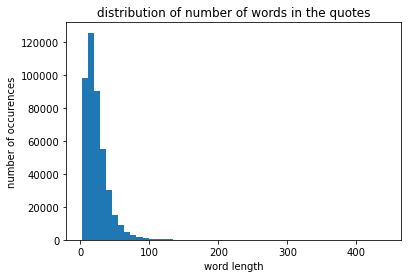

In [3]:
import matplotlib.pyplot as plt
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 
lista = []
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
        instance = json.loads(instance)
        text = instance['quotation']
        lista.append(len(text.split()))

plt.hist(lista, bins = 50)
plt.xlabel('word length')
plt.ylabel('number of occurences')
plt.title('distribution of number of words in the quotes')
plt.show()

If we just look at all the data everything looks kind of normal, but let's zoom on the larger values

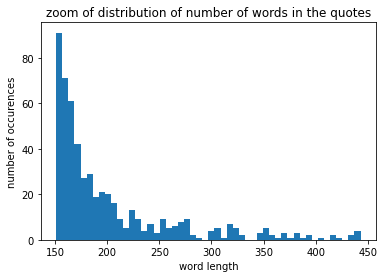

In [4]:
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 
lista = []
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
            instance = json.loads(instance)
            text = instance['quotation']
            if len(text.split()) > 150:
                lista.append(len(text.split()))

plt.hist(lista, bins = 50)
plt.xlabel('word length')
plt.ylabel('number of occurences')
plt.title('zoom of distribution of number of words in the quotes')
plt.show()

From 300 to 450 the data seems to have a distribution almost uniform but it's true that the number of quotation is low and therfore it could be fine. Lets read some of this long quotes!

In [5]:
lista = []
cnt = 0
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
            instance = json.loads(instance)
            text = instance['quotation']
            lista.append(len(text.split()))
            if len(text.split()) > 400:
                print(text)
                print('-------------------------------------------------------')

where the virus first emerged late last year, and which has suffered the vast majority of infections -- by imposing travel controls and shutting down public events. Italy on Saturday saw its biggest daily increase in coronavirus cases since the outbreak began in the north of the country on Feb. 21. In its daily update, Italy's civil protection agency said the number of people with the coronavirus rose by 1,247 in the last 24 hours, taking the total to 5,883. Another 36 people also died as a result of the virus, taking the total to 233. There was chaos and confusion in the northern Italian city of Padua in the Veneto region as word spread late Saturday evening that the government was planning to announce the quarantine. Packed bars and restaurants quickly emptied out as many people rushed to the train station in Padua. Travellers with suitcases, wearing face masks, gloves and carrying bottles of sanitizing gel shoved their way on to trains. Before Conte signed the quarantine decree, Ste

Most of the quotes looks good, even if some are clearly not quotes (look at the last one), but many contains weird 'â € ','â € ™','â € ' sequences of characters! 

In [6]:
import bz2
import json
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 

cnt = 0
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
        instance = json.loads(instance)
        text = instance['quotation']
        if 'â € ' in text or 'â € ™' in text:
            cnt +=1

print(cnt)

74


A quick research on google and we convninced ourselfs that this problem is coming from a UTF-8 encoding bug when creating the datset. (see https://www.i18nqa.com/debug/utf8-debug.html) which occurs either when the dataset is created or which is present on the website from which the quote is extracted. We find strange the high concentration of these bugs within the longer citations in fact within the whole dataset we studied only 74 citations contain these bugs. Let's print the problematic char to be sure that the problem is not the jupyter notebook not supporting this special chars.

In [7]:
print('“')

“


Lastly let's check in one of the original text if the bug is alredy present using the url present in the raw dataset. Since all the urls bring us to a single website we assume that the bug is in there.

In [8]:
path_to_file = QUOTES_2020_PARTY_LABELED_COMPLETE
set_of_websites = set()
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
            instance = json.loads(instance)
            text = instance['quotation']
            if 'â € ' in text or 'â € ™' in text:
                set_of_websites.add(instance['urls'][0][0:27])
                
set_of_websites

{'https://medicinehatnews.com'}

Lets analyse the medium lenght of the sentences between republicans and democrats. 


In [9]:
path_to_file = QUOTES_2020_PARTY_LABELED_PATH


labeled_df = pd.io.json.read_json(path_to_file, lines=True)

def get_info(x):
    x = x.split(" ")
    return len(x)
labeled_df["length_quote"] = labeled_df["quotation"].apply(lambda x: get_info(x))

mean_quote_lenght_D = labeled_df[labeled_df["party_label"] == "D"]["length_quote"].median()
mean_quote_lenght_R = labeled_df[labeled_df["party_label"] == "R"]["length_quote"].median()
print(mean_quote_lenght_D)
print(mean_quote_lenght_R)

19.0
19.0


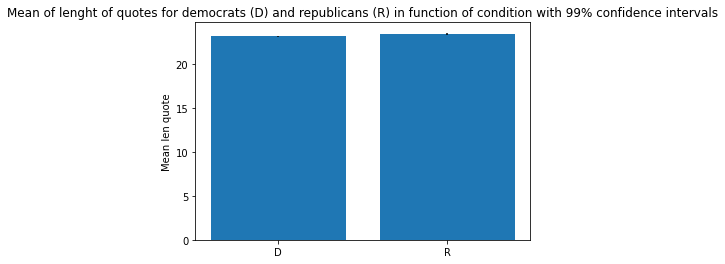

In [10]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    return [np.nanpercentile(means, 0.05),np.nanpercentile(means, 99.5)]

mean_dem ,mean_rep = labeled_df.groupby(by="party_label").mean()["length_quote"]

party_label = labeled_df.groupby("party_label")["length_quote"].apply(lambda x : x.tolist())

[lower_dem,upper_dem] = bootstrap_CI(party_label.iloc[0],1000)
[lower_rep,upper_rep] = bootstrap_CI(party_label.iloc[1],1000)

plt.bar([str(party_label.index[0]),str(party_label.index[1])],[mean_dem,mean_rep],yerr = [[mean_dem-lower_dem,mean_rep-lower_rep],[upper_dem-mean_dem,upper_rep-mean_rep]])
plt.ylabel("Mean len quote")
plt.title("Mean of lenght of quotes for democrats (D) and republicans (R) in function of condition with 99% confidence intervals");

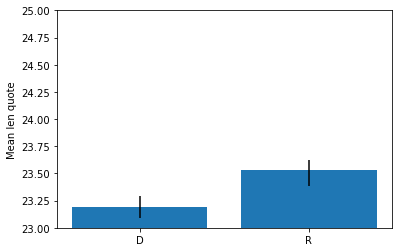

In [11]:
plt.bar([str(party_label.index[0]),str(party_label.index[1])],[mean_dem,mean_rep],yerr = [[mean_dem-lower_dem,mean_rep-lower_rep],[upper_dem-mean_dem,upper_rep-mean_rep]])
plt.ylabel("Mean len quote")
plt.ylim(23,25);

## 2. Let's analyize the distribution of number of quotes in time.

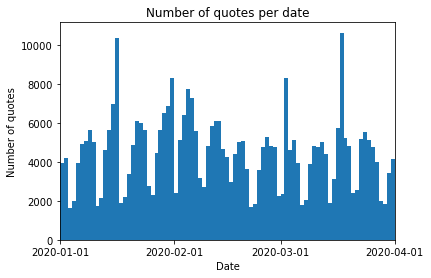

In [12]:
formatted_df = labeled_df.copy()
formatted_df["date"] = pd.to_datetime(formatted_df['date'], format='%Y-%m-%d %H:%M:%S')

#plot the data
bins = 100
hist = plt.hist(formatted_df["date"].dt.date,bins)
plt.xlim([datetime.date(2020, 3, 15), datetime.date(2020, 4, 1)])
plt.xticks([datetime.date(2020, i, 1) for i in range(1,5)])
plt.xlabel("Date")
plt.ylabel("Number of quotes")
plt.title("Number of quotes per date")
plt.show()

What are those drops? Lets check the first 2 months by printing the dates

In [13]:
#we range over two months over each day and we print the dates which have less than 3500 quotes (a bit less than the average)
for j in range(1,2):
   for i in range(1,30):
       if len(formatted_df[formatted_df.values == datetime.date(2020,j,i)]) < 3500:
           print('2020-%d-%d' % (j,i))

<ipython-input-13-bfde1d8c6e15>:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if len(formatted_df[formatted_df.values == datetime.date(2020,j,i)]) < 3500:


2020-1-1
2020-1-2
2020-1-4
2020-1-5
2020-1-11
2020-1-12
2020-1-18
2020-1-19
2020-1-20
2020-1-25
2020-1-26


As we can see from these values, by checking in the calendar, these drops correspond to the weekends / holidays day, in which we assume that no quotes where inserted in the newspaper the plot.

Now lets analysis the spikes instead. We firsty get the top 10 most frequent dates of quotes, and later show them on the graph.

In [14]:
# get top 10 most frequent dates of quotes
n = 10
days_with_most_quotes = formatted_df['date'].value_counts()[:n].index.tolist()
days_with_most_quotes

[Timestamp('2020-02-05 00:00:00'),
 Timestamp('2020-02-04 00:00:00'),
 Timestamp('2020-01-15 00:00:00'),
 Timestamp('2020-01-30 00:00:00'),
 Timestamp('2020-02-07 00:00:00'),
 Timestamp('2020-01-14 00:00:00'),
 Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-03-17 00:00:00'),
 Timestamp('2020-02-06 00:00:00'),
 Timestamp('2020-03-24 00:00:00')]

By checking the dates with the calendar, we found that these dates are related to presidential events. Lets see some examples:
- 2020-01-15 -> the Pentagon construction was completed.
- 2020-01-30 -> President Trump signed the U.S.-Mexico-Canada (USMCA) trade pact.
- 2020-02-05: "Trump impeachment vote live updates: Sharply divided Senate acquits Trump on both articles"
- 2020-02-07 -> "United States President Donald Trump is acquitted by the United States Senate in his first impeachment trial."

Lets display them on the graph.

In [15]:
events = {datetime.date(2020, 2, 5):'T. Imp.',
          datetime.date(2020, 1, 15): 'Pentagon',
          datetime.date(2020, 1, 30):'U-M-C'}
events_keys = []
events_values = []
for i in events.keys():
    events_keys.append(i)
for j in events.values():
    events_values.append(j)

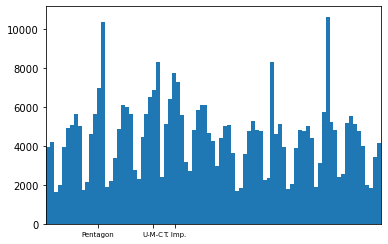

In [16]:
bins = 100
hist = plt.hist(formatted_df["date"].dt.date,bins)
plt.xlim([datetime.date(2020, 1, 1), datetime.date(2020,4, 1)])
plt.xticks([events_keys[i] for i in range(0,len(events_keys))],[events_values[i] for i in range(0,len(events_values))],fontsize=7)
plt.show()

MONO ANALYSIS

## 3.Let's analyize the words used in the quotes

MICHAEL ANALYSIS FROM ?

# DUPLICATES ANALISYS
Let's just analize if there are duplicates in the quotations. If we just take quotations as they are we cannot see any duplicates but with a bit of processing we can easily spot some...

In [2]:


path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 



#Read the dataset
testdf = pd.io.json.read_json(path_to_file, lines=True)
#Put every letter to lowercase, remove whitespaces and punctuation
custom_pipeline = [preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_punctuation]
testdf['clean_quotes'] = hero.clean(testdf['quotation'], custom_pipeline)

#Check for duplicate in the original and in the cleaned version
print(testdf['quotation'].duplicated().sum())
print(testdf['clean_quotes'].duplicated().sum())
#print some duplicate sentences
testdf[testdf['clean_quotes'].duplicated()]['quotation'].head(5)

0
790


10099    jerry-rig the system and go around the Constit...
17562    There will be a huge amount of pent-up demand ...
17571    I can assure you, the president is determined,...
20314    These cameras are nothing more than a get rich...
26320        we're talking about a sharp escalation ahead.
Name: quotation, dtype: object

In [3]:
#let's visualize the two quotes: this are indeed duplicates
testdf[testdf['clean_quotes']==testdf['clean_quotes'].iloc[10099]]

,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID,clean_quotes
6567,2020-02-17-041872,jerry rig the system and go around the Constit...,Stacey Abrams,2020-02-17 20:57:04,1,Q7595813,D,None,jerry rig the system and go around the constit...
10099,2020-02-19-052071,jerry-rig the system and go around the Constit...,Stacey Abrams,2020-02-19 00:00:00,2,Q7595813,D,None,jerry rig the system and go around the constit...


This means that we need to do some cleaning. Of course this analisys is not complete we need to find a more systematic way to spot duplicates. To spot duplicates we use Jaccard similarity between pairs of quotes of the same speaker. 

The pipeline for identifying highly similar quotes is fairly simple:
* Group the dataframe by speaker
* compute the jaccard similarity between pairs of quotes of a speaker. If the similarity is higher than the threshold, drop the shorter quote

Jaccard similarity is useful for identifying similar sentences. It does this by identifying the number of common words there are in both sentences.The formula is given by:

 `jaccard_similarity = size(quote_a intersection quote_b) /size(quote_a union quote_b))`

 If the `jaccard_similarity = 1`, all the words in quote_a are in quote_b and vice versa. If the `jaccard_similarity = 0`, there are no common words among both quotes. Note that Jaccard similarity 
 doesn't take into account the position of words in a sentence



Here is an example on a subset of the dataset:

In [4]:
dataframe_to_clean = pd.read_json(QUOTES_2020_PARTY_LABELED_CLEANED_PATH, lines=True, compression='bz2', nrows = 20000)
cleaned_df = remove_duplicates(dataframe = dataframe_to_clean,threshold = 0.7)

print('dataframe size before cleaning:'  + str(dataframe_to_clean.shape[0]))
print('dataframe size after cleaning:'  + str(cleaned_df.shape[0]))


/Users/nicolasbaldwin/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


dataframe size before cleaning:20000
dataframe size after cleaning:19789


This method removes duplicates like the ones in the previous section:

In [5]:
print('dataframe before cleaning:')
display(dataframe_to_clean[dataframe_to_clean['quoteID'].isin(['2020-02-17-041872','2020-02-19-052071'])])
print('dataframe after cleaning:')
display(cleaned_df[cleaned_df['quoteID'].isin(['2020-02-17-041872','2020-02-19-052071'])])

dataframe before cleaning:


,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID
6567,2020-02-17-041872,jerry rig system go around constitution,stacey abrams,2020-02-17 20:57:04,1,Q7595813,D,None
10099,2020-02-19-052071,jerry rig system go around constitution,stacey abrams,2020-02-19 00:00:00,2,Q7595813,D,None


dataframe after cleaning:


,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID
6567,2020-02-17-041872,jerry rig system go around constitution,stacey abrams,2020-02-17 20:57:04,1,Q7595813,D,None


But it also drops quotes that have a high similarity:

In [18]:
df_to_clean_quotes = dataframe_to_clean['quotation'].unique()
cleaned_df_quotes = cleaned_df['quotation'].unique()
removed_quote = list(filter(lambda x: x not in cleaned_df_quotes, df_to_clean_quotes))[0]

cleaned_df['similarity to removed quote'] = cleaned_df['quotation'].apply(lambda x: jaccard_sim((x,removed_quote)))

max_similarity = cleaned_df['similarity to removed quote'].max()

print('removed_quote:')
print(removed_quote)
print()
print('quote most similar in cleaned dataframe:')
print(cleaned_df[cleaned_df['similarity to removed quote'] == max_similarity].quotation.item())
print()
print('with similarity = ' + str(max_similarity))

cleaned_df = cleaned_df.drop(columns=['similarity to removed quote'])



removed_quote:
president trump say go cultural site

quote most similar in cleaned dataframe:
president trump say go cultural site read said

with similarity = 0.75


As we can see, the these 2 quotes are extremely similar.

# HOW HARD IS OUR TASK?
To have a sense of how hard the task will be let's try to analise the data distribution in a lower dimension. To do that we need to transform the text into a numeric format, using tf-idf model,  then apply PCA to the result. Before representing quotes as vectors we preprocess the data. As we can  see the data does not look to be separable by class in the PCA plot. This is completely possible because PCA attempts to find eigenvectors that explain the most the variance of our vectors. As we can see the most explained variances are more specific to our encoding than our party label (which is not encoded in our tfidf vectors). 

In [19]:
## arguments:
    ## dataframe: dataframe containing quotes, the data frame must have at least 2 columns: 'party_label' and ' quotation'
    ## keyword: only used if use_keyword = True, allows us to do analysis with only quotes that include the keyword
    ## use_keyword: specifies if we must use the keyword to to do analysis with only quotes that include the keyword
    ##removeVerbs: if set to true, we remove all verbs from the quotes
def pca(dataframe,keyword = None, use_keyword = False,removeVerbs = False):
    """ function that performs pca on quote and plots their position with respect to the 2 most meaningful vectors """

    print(dataframe[dataframe['party_label']=='D'].shape)
    print(dataframe[dataframe['party_label']=='R'].shape)

    df = dataframe.copy()
    #clean quote
    df['quotation'] = clean(df['quotation'])

    if use_keyword:
        #extract only quotes that include keyword
        df = df[df['quotation'].str.contains(keyword)]
        #remove keyword from quotes
        df['quotation'] = df['quotation'].apply(lambda x: x.replace(keyword, ''))

    if removeVerbs:
        #remove verbs from quotes
        df['quotation'] = remove_verbs(df['quotation'])

    #vectorization of the sentences
    df['tfidf'] = hero.tfidf(df['quotation'])
    #perform pca
    df['pca'] = hero.pca(df['tfidf'])
    #plot
    hero.scatterplot(
        df, 
        col='pca', 
        color='party_label', 
        title="PCA for quotes containing word " + keyword if use_keyword else '',
        hover_data = ['quotation','speaker']
    )



We will now train a small classification model and see if our main goal is feasible.

In [56]:
#NEED BALANCED DATA!!
labeled_df = pd.io.json.read_json(path_to_file, lines=True)

#labeled_df_senators = labeled_df[labeled_df['US_congress_bio_ID'] != 'None']
labeled_df_dem= labeled_df[labeled_df['party_label']=='D'].head(20000)
labeled_df_rep= labeled_df[labeled_df['party_label']=='R'].head(20000)
labeled_df_senators = pd.concat([labeled_df_dem, labeled_df_rep])
labeled_df_senators['vect_quotes'] = labeled_df_senators['quotation'].pipe(hero.clean).pipe(hero.tfidf)

X = labeled_df_senators[labeled_df['US_congress_bio_ID'] != 'None']['vect_quotes'].tolist()
y = labeled_df_senators[labeled_df['US_congress_bio_ID'] != 'None']['party_label'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

print('xshape: ',len(X),'yshape: ',len(y))
clf = RandomForestClassifier(n_estimators=10)

scores = cross_val_score(clf, X,y, cv=5)
scores.mean()